In [1]:
import time

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import plotly.graph_objects as go
import statsmodels.api as sm
from pylab import rcParams
import itertools
import datetime
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from math import sqrt
from fbprophet import Prophet
import json
from fbprophet.serialize import model_to_json
# # For loading
# from fbprophet.serialize import model_from_json

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Retail Sales Forecasting #

In the previous notebook we went through an extensive set of tutorials diving into the inner workings of time series analysis with TensorFlow.  This notebook will put it to practice in a meaningful way predicting future retail sales, a very common challenge for many businesses worldwide.

We will be using the Superstore Sales dataset from kaggle.  It can be found here https://www.kaggle.com/rohitsahoo/sales-forecasting.

# Exploratory Data Analysis #

As always, start with some basic EDA

### Data Cleaning ###

In [3]:
# Read in the dataset from Google drive
df = pd.read_csv('/content/drive/MyDrive/time_series_analysis/data/superstore.csv')

In [4]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [5]:
# Descriptive Statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Row ID,9800.0,4900.500000,2829.160653,1.000,2450.750,4900.50,7350.250,9800.00
Postal Code,9789.0,55273.322403,32041.223413,1040.000,23223.000,58103.00,90008.000,99301.00
Sales,9800.0,230.769059,626.651875,0.444,17.248,54.49,210.605,22638.48


In [6]:
# Row ID column is redundant, we can drop it
df.drop('Row ID', axis=1, inplace=True)
new_df = pd.DataFrame(df)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9800 non-null   object 
 1   Order Date     9800 non-null   object 
 2   Ship Date      9800 non-null   object 
 3   Ship Mode      9800 non-null   object 
 4   Customer ID    9800 non-null   object 
 5   Customer Name  9800 non-null   object 
 6   Segment        9800 non-null   object 
 7   Country        9800 non-null   object 
 8   City           9800 non-null   object 
 9   State          9800 non-null   object 
 10  Postal Code    9789 non-null   float64
 11  Region         9800 non-null   object 
 12  Product ID     9800 non-null   object 
 13  Category       9800 non-null   object 
 14  Sub-Category   9800 non-null   object 
 15  Product Name   9800 non-null   object 
 16  Sales          9800 non-null   float64
dtypes: float64(2), object(15)
memory usage: 1.3+ MB


We need to convert that order and ship date into a datetime

In [8]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')

In [9]:
# Sort by order date
df.sort_values(by=['Order Date'], inplace=True, ascending=True)

In [10]:
# Reset index as Order Date
df = df.set_index('Order Date')
df.index

DatetimeIndex(['2015-01-03', '2015-01-04', '2015-01-04', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-06', '2015-01-06',
               '2015-01-06', '2015-01-06',
               ...
               '2018-12-29', '2018-12-29', '2018-12-29', '2018-12-30',
               '2018-12-30', '2018-12-30', '2018-12-30', '2018-12-30',
               '2018-12-30', '2018-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=9800, freq=None)

In [11]:
# Check for nulls
df.isnull().mean()*100

Order ID         0.000000
Ship Date        0.000000
Ship Mode        0.000000
Customer ID      0.000000
Customer Name    0.000000
Segment          0.000000
Country          0.000000
City             0.000000
State            0.000000
Postal Code      0.112245
Region           0.000000
Product ID       0.000000
Category         0.000000
Sub-Category     0.000000
Product Name     0.000000
Sales            0.000000
dtype: float64

Okay, the only feature missing information is Postal Code.  It is relatively small, we could throw it out - but let's try to figure something out first.

In [12]:
df[df['Postal Code'].isnull()]

,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Order Date,,,,,,,,,,,,,,,,
2016-11-07,CA-2016-162887,2016-11-09,Second Class,SV-20785,Stewart Visinsky,Consumer,United States,Burlington,Vermont,NaN,East,FUR-CH-10000595,Furniture,Chairs,Safco Contoured Stacking Chairs,715.20
2016-11-08,CA-2016-117086,2016-11-12,Standard Class,QJ-19255,Quincy Jones,Corporate,United States,Burlington,Vermont,NaN,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",4404.90
2017-01-23,US-2017-165505,2017-01-27,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,99.98
2017-01-23,US-2017-165505,2017-01-27,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-ST-10001526,Office Supplies,Storage,Iceberg Mobile Mega Data/Printer Cart,1564.29
2017-01-23,US-2017-165505,2017-01-27,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-AR-10003477,Office Supplies,Art,4009 Highlighters,8.04
2017-04-06,US-2017-150140,2017-04-10,Standard Class,VM-21685,Valerie Mitchum,Home Office,United States,Burlington,Vermont,NaN,East,TEC-PH-10002555,Technology,Phones,Nortel Meridian M5316 Digital phone,1294.75
2018-01-19,US-2018-127292,2018-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-AP-10000828,Office Supplies,Appliances,Avanti 4.4 Cu. Ft. Refrigerator,542.94
2018-01-19,US-2018-127292,2018-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-EN-10001509,Office Supplies,Envelopes,Poly String Tie Envelopes,2.04
2018-01-19,US-2018-127292,2018-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,12.28


Good news!  The missing postal codes are all from the same city, Burlington Vermont.  That is an easy fix after Googling to find out the zip code should be 5401

In [13]:
df['Postal Code'] = df['Postal Code'].fillna(5401)

In [14]:
df.isnull().sum()

Order ID         0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
dtype: int64

In [15]:
df.head()

,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Order Date,,,,,,,,,,,,,,,,
2015-01-03,CA-2015-103800,2015-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,Texas,77095.0,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448
2015-01-04,CA-2015-112326,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540.0,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540
2015-01-04,CA-2015-112326,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540.0,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736
2015-01-04,CA-2015-112326,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540.0,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784
2015-01-05,CA-2015-141817,2015-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,Pennsylvania,19143.0,East,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536


### Data Visualizations ###

Although we could go ahead and dive into the modeling, there are plenty of insights that can be gained just by exploring the dataset further.

A data scientist working in the retail space may be asked to help prioritize consumers, regions, categories, etc.  Let's take a look!

In [16]:
# Sort the top 20 customers by sales
top_customers = df.groupby(['Customer Name']).sum().sort_values('Sales', ascending=False).head(20)
top_customers = top_customers[['Sales']].round(2)
top_customers.reset_index(inplace=True)

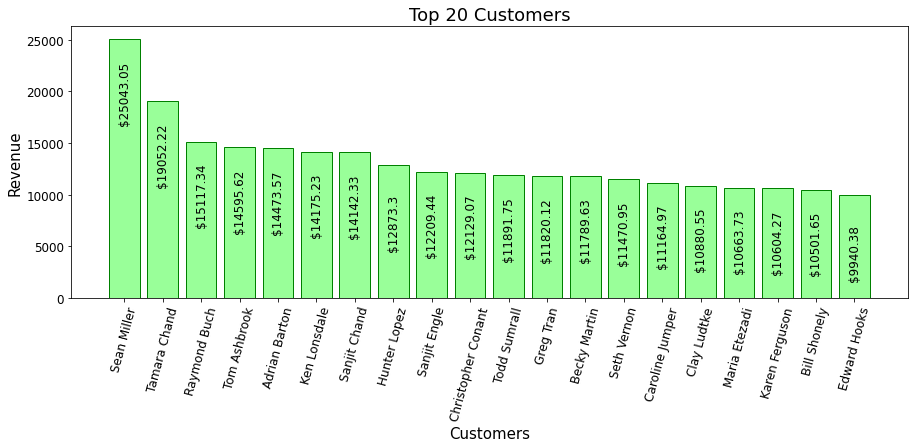

In [17]:
plt.figure(figsize = (15,5)) # width and height of figure is defined in inches
plt.title("Top 20 Customers", fontsize=18) 
plt.bar(top_customers["Customer Name"], top_customers["Sales"],color= '#99ff99',edgecolor='green', linewidth = 1)
plt.xlabel("Customers",fontsize=15) # x axis shows the customers 
plt.ylabel("Revenue",fontsize=15) # y axis shows the Revenue
plt.xticks(fontsize=12, rotation=75)
plt.yticks(fontsize=12)
for k,v in top_customers["Sales"].items(): #To show the exact revenue generated on the figure
    plt.text(k,v-8000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center');

Looks like this Sean Miller buys a lot of stuff...must run a small business or something.  Let's look at our sales on more of a state-level.  The top 10 states, and also we can visualize it on a map.

In [18]:
top_states = df.groupby(['State']).sum().sort_values('Sales', ascending=False).head(10)
top_states = top_states[['Sales']].round(2)
top_states.reset_index(inplace=True)

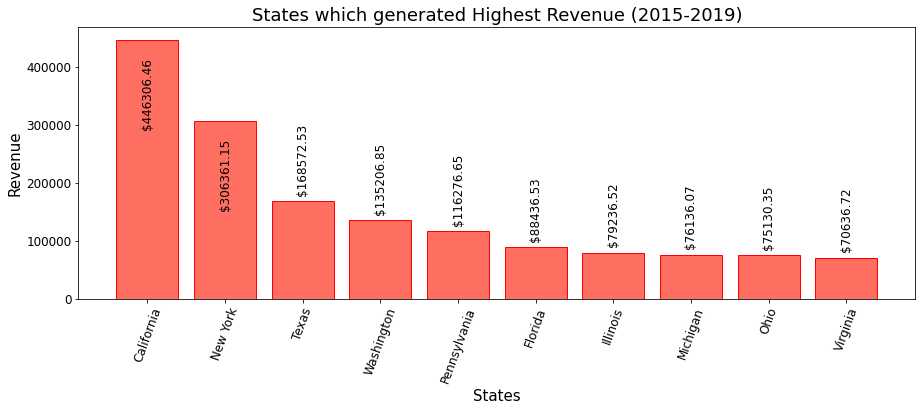

In [19]:
plt.figure(figsize = (15,5)) # width and height of figure is defined in inches
plt.title("States which generated Highest Revenue (2015-2019)", fontsize=18) 
plt.bar(top_states["State"], top_states["Sales"],color= '#FF6F61',edgecolor='Red', linewidth = 1)
plt.xlabel("States",fontsize=15) # x axis shows the States
plt.ylabel("Revenue",fontsize=15) # y axis shows the Revenue
plt.xticks(fontsize=12, rotation=70)
plt.yticks(fontsize=12)
for k,v in top_states["Sales"].items(): #To show the exact revenue generated on the figure
    if v>300000:
        plt.text(k,v-150000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center');
    else:
        plt.text(k,v+15000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center');

In [20]:
# First we need to create a list of state names and abbreviated codes
state = ['Alabama', 'Arizona' ,'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 
         'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
         'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana','Nebraska', 'Nevada', 'New Hampshire',
         'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
         'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
         'West Virginia', 'Wisconsin','Wyoming']
state_code = ['AL','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA',
              'MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN',
              'TX','UT','VT','VA','WA','WV','WI','WY']

In [21]:
# Create a df for the states
state_df = pd.DataFrame(state, state_code)
state_df.reset_index(level=0, inplace=True)
state_df.columns = ['State Code','State']
# And one for the sales
sales = df.groupby(["State"]).sum().sort_values("Sales", ascending=False)
sales.reset_index(level=0, inplace=True)
sales.drop('Postal Code',1, inplace = True)
sales= sales.sort_values('State', ascending=True)
sales.reset_index(inplace = True)
sales.drop('index',1,inplace = True)
sales.insert(1, 'State Code', state_df['State Code'])

In [22]:
sales['text'] = sales['State']
fig = go.Figure(data=go.Choropleth(
    locations=sales['State Code'], # Spatial coordinates
    text=sales['text'],
    z = sales['Sales'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Sales",
    
))

fig.update_layout(
    title_text = 'Sales',
    geo_scope='usa', # limite map scope to USA
)

fig.show();

Awesome!  We have ranked our top states and shown them on the map.

Now we just need to save a new df of the sales and we are good to go.

Note - the data can be tricky to work with still, we will simplify by using the average daily sales for each month.

In [23]:
top_categories = df.groupby(['Category']).sum().sort_values('Sales', ascending=False).head(10)
top_categories = top_categories[['Sales']].round(2)
top_categories.reset_index(inplace=True)
top_categories.head()

,Category,Sales
0,Technology,827455.87
1,Furniture,728658.58
2,Office Supplies,705422.33


Okay great, we have 3 separate categories.  Let's break them apart so we can forecast their sales individually.

In [24]:
tech_df = pd.DataFrame(df.loc[df['Category'] == 'Technology'])
furniture_df = pd.DataFrame(df.loc[df['Category'] == 'Furniture'])
office_df = pd.DataFrame(df.loc[df['Category'] == 'Office Supplies'])

# Select Sales to Forecast #

We can choose to forecast the sales together or individually.  Our code is set up to choose which now, and will run the rest of the notebook on that selection.

Select between
1. df (all sales)
2. tech_df
3. furniture_df
4. office_df

In [25]:
# Select dataframe
temp_df = df
resample = 'MS'

In [26]:
new_df = pd.DataFrame(temp_df['Sales'])
# Resample the average of daily sales 
new_df = pd.DataFrame(new_df['Sales'].resample(resample).mean())
new_df = new_df.interpolate(method='linear')
new_df.head()

,Sales
Order Date,
2015-01-01,184.489701
2015-02-01,98.258522
2015-03-01,358.479201
2015-04-01,214.668115
2015-05-01,195.407463


In [27]:
# Train / Test / Validate Split
train_df, test_df, val_df = np.split(
    new_df['Sales'].sample(frac=1), 
    [int(.6*len(new_df['Sales'])), int(.8*len(new_df['Sales']))]
    )

In [28]:
# Normalize 
# Do not include test or val in mean calculation to avoid information leakage
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [29]:
def analyze_time_series(time_series_df):
  rcParams['figure.figsize'] = 18, 8
  decomposition = sm.tsa.seasonal_decompose(time_series_df, model='additive')
  fig = decomposition.plot()
  plt.show()

Plot the time series and decompose into trend and seasonality

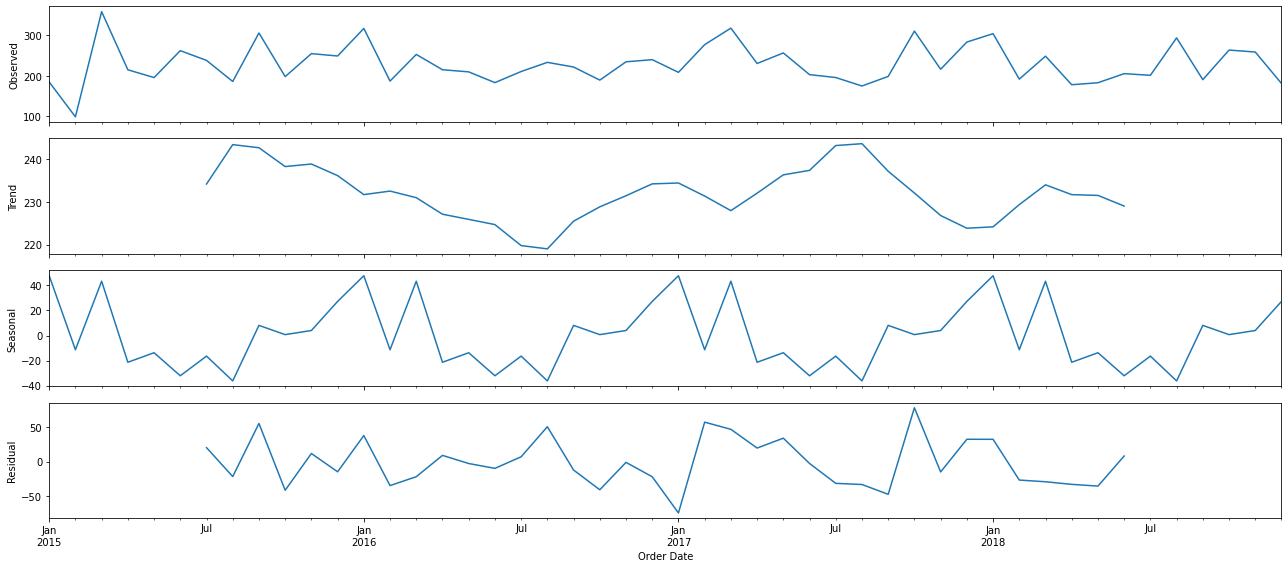

In [30]:
analyze_time_series(new_df)

This plot shows some clear seasonality, and overal unstable sales.

# Time Series Analysis #

Okay, that's enough EDA for now.  You can spend plenty of time just exploring the dataset, but go ahead and dive into forecasting with SARIMAX and PROPHET.

The Autoregressive Integrated Moving Average, or ARIMA is a very powerful forecasting technique.  Even more powerful yet, is when you use multiple input features upgrading to the ARIMAX, but you can upgrade even further with the Seasonal ARIMAX, or SARIMAX which we will be using today.

For now, we will just focus on forcecasting the Furniture sales

## SARIMAX ##

SARIMAX models are denoted as SARIMAX(p,d,q)

p,d,q represent seaonality, trend, and noise in the data and can be tuned to your dataset for optimal performance.

In [31]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMAX...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMAX...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Now we need to find the optimal combination of these parameters.  We can do this by performing a quick gridsearch and looking for the minimum AIC which represents the relative amount of information lost by the model.

In [32]:
for parameters in pdq: #for loop for determining the best combination of seasonal parameters for SARIMA
    for seasonal_param in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(new_df,
                                            order=parameters,
                                            seasonal_param_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False) #determines the AIC value of the model**
            results = mod.fit()
            print('SARIMAX{}x{}12 - AIC:{}'.format(parameters, seasonal_param, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:648.689981524478
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:648.689981524478
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:648.689981524478
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:648.689981524478
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:648.689981524478
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:648.689981524478
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:648.689981524478
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:648.689981524478
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:597.6634244866564
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:597.6634244866564
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:597.6634244866564
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:597.6634244866564
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:597.6634244866564
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:597.6634244866564
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:597.6634244866564
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:597.6634244866564
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:529.3704763082351
SARIMAX(0, 1, 0)x(0, 0, 1, 12)12 - AIC:

It looks like we should use the SARIMAX(1, 1, 1)x(1, 1, 1, 12)12 - AIC:20377.366491082863 parameters for our model (there are multiple options with the same min AIC)

Let's fit the model

In [33]:
mod = sm.tsa.statespace.SARIMAX(new_df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0997      0.250     -0.399      0.690      -0.590       0.390
ma.L1         -1.0000   1169.638     -0.001      0.999   -2293.449    2291.449
ar.S.L12      -0.5849      0.177     -3.301      0.001      -0.932      -0.238
sigma2      2481.6348    2.9e+06      0.001      0.999   -5.69e+06    5.69e+06


Take a look at the diagnostics of the SARIMAX model.

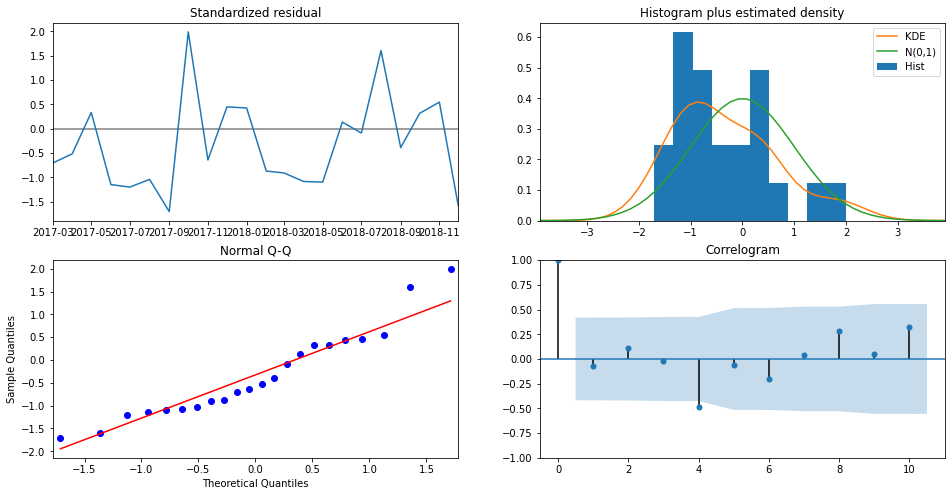

In [34]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Not the best model ever, but it looks pretty good to play around with.  Let's see what type of forecasting we can do.

# Time Series Forecasting #

Let's validate our forecasts by testing it on the most recent year in the dataset.

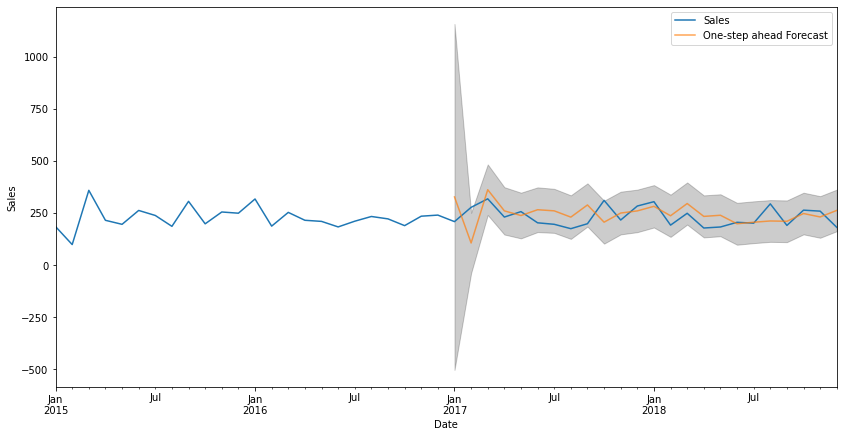

In [35]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = new_df['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [36]:
y_forecasted = pred.predicted_mean
y_truth = new_df['2017-01-01':]

mse = mean_squared_error(y_forecasted, y_truth)
rmse = sqrt(mse)
print('The Root Mean Squared Error of the forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of the forecasts is 65.88


In [37]:
forecast = results.forecast(steps=7) # making a forecast of 7 days later of the last date in the 'Order Date' column
print(forecast.astype('int')) #displays the sales forecast as type integer

2019-01-01    259
2019-02-01    244
2019-03-01    292
2019-04-01    212
2019-05-01    229
2019-06-01    207
2019-07-01    201
Freq: MS, dtype: int64


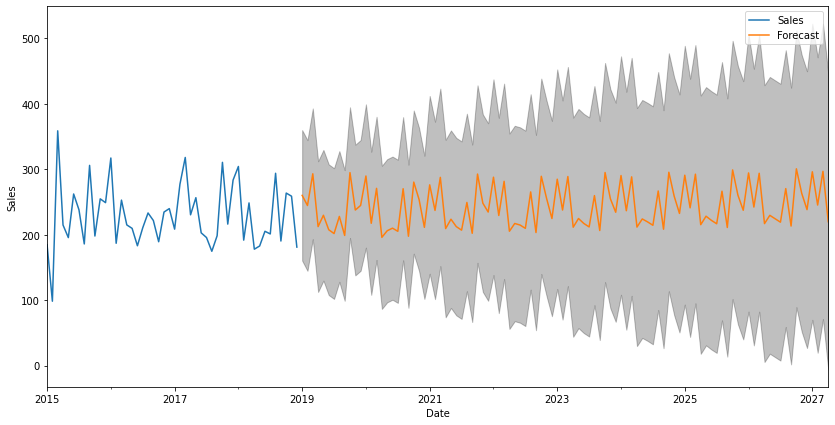

In [38]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = new_df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

### Save the Predictions ###

Now that we have made our predictions, the interested stakeholders would probably like to have them in a nice .csv file to work with in the visualization tools and their own analysis.

In [39]:
#saving the sales values as type integer
forecast = forecast.astype('int') 
# forecast is in Series form, converting it to DataFrame
forecast_df = forecast.to_frame() 
# converting the index to column
forecast_df.reset_index(level=0, inplace=True) 
# giving appropriate names to the output columns
forecast_df.columns = ['Prediction Date', 'Predicted Sales'] 
# saving the output as a csv file with name 'prediction.csv'
prediction = pd.DataFrame(forecast_df).to_csv('/content/drive/MyDrive/time_series_analysis/forecasts/sarimax_prediction.csv',index=False) 

# Prophet #

Facebook Prophet model is an excellent forecasting tool.  It has advanced capabilities to learn holidays, weekends, time of day, etc.

In [40]:
# Clean up the dataframes, drop everything we don't need
cols = ['Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name']
df.drop(cols, axis=1, inplace=True)
tech_df.drop(cols, axis=1, inplace=True)
furniture_df.drop(cols, axis=1, inplace=True)
office_df.drop(cols, axis=1, inplace=True)

In [41]:
def prophet_preprocessing(df, resample='MS'):
  # Resulting dataframe will be two columns, Order Date and Sales sorted by date
  df = df.sort_values('Order Date')
  df = df.groupby('Order Date')['Sales'].sum().reset_index()
  df = df.set_index('Order Date')
  y_df = df['Sales'].resample(resample).mean()
  df = pd.DataFrame({'Order Date': y_df.index, 'Sales': y_df.values})
  return df

In [42]:
# Preprocess our individual dataframes
sales_df = prophet_preprocessing(df, resample)
tech_df = prophet_preprocessing(tech_df, resample)
furniture_df = prophet_preprocessing(furniture_df, resample)
office_df = prophet_preprocessing(office_df, resample)

In [43]:
def run_prophet(name, df, interval_width=0.95, periods=36, resample='MS'):
  # Format the data specifically for the prophet tool
  prophet_df = df.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
  # Generate and fit the Prophet
  model = Prophet(interval_width=interval_width)
  model.fit(prophet_df)
  # Make a forecast
  forecast = model.make_future_dataframe(periods=periods, freq=resample)
  forecast = model.predict(forecast)
  # Save the model
  with open(f'/content/drive/MyDrive/time_series_analysis/forecasts/{name}_serialized_model.json', 'w') as fout:
    json.dump(model_to_json(model), fout)  # Save model
  # # Code to load the model in another notebook
  # with open('/content/drive/MyDrive/time_series_analysis/forecasts/serialized_model.json', 'r') as fin:
  #   m = model_from_json(json.load(fin))  # Load model  

  # Show the results
  plt.figure(figsize=(18, 6))
  model.plot(forecast, xlabel = 'Date', ylabel = 'Sales')
  plt.title(f'{name} Sales');

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

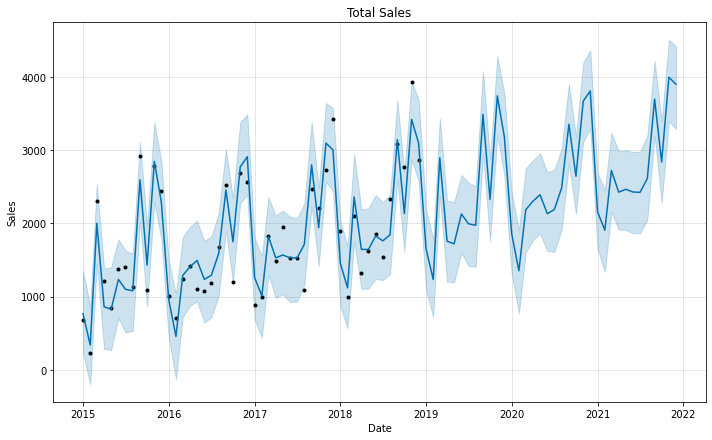

<Figure size 1296x432 with 0 Axes>

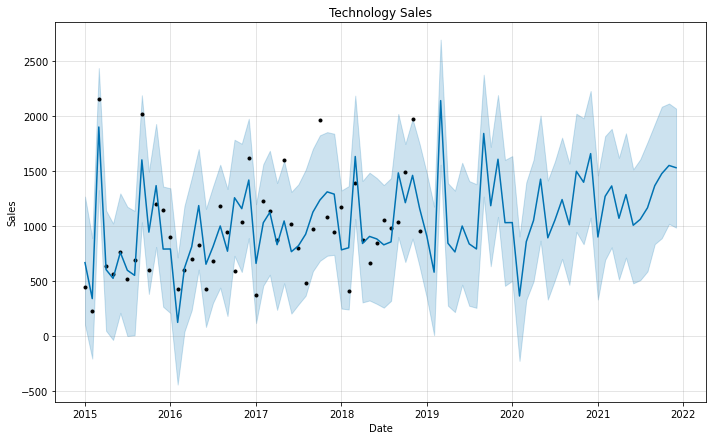

<Figure size 1296x432 with 0 Axes>

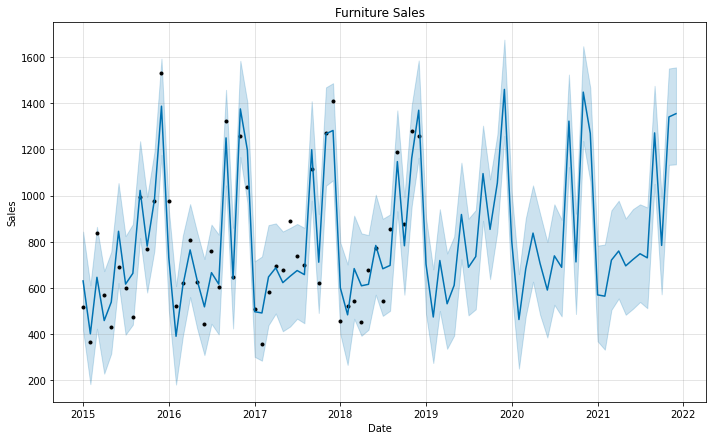

<Figure size 1296x432 with 0 Axes>

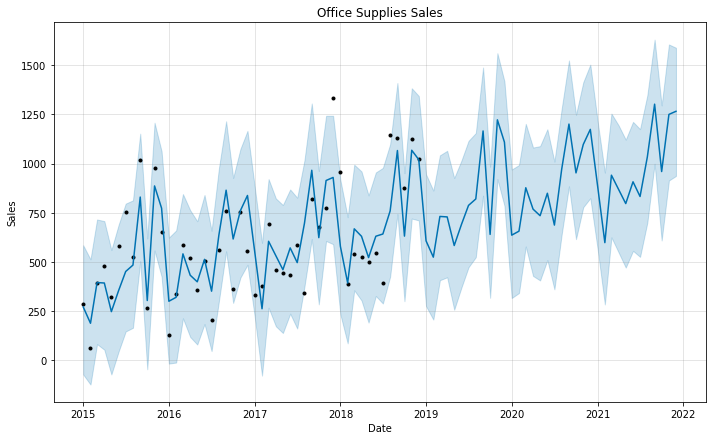

In [44]:
# Run the Prophet
run_prophet('Total', sales_df)
run_prophet('Technology', tech_df)
run_prophet('Furniture', furniture_df)
run_prophet('Office Supplies', office_df)